## Image classification from scratch

### Setup

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import random_split
from torchvision import datasets,transforms
from torch.utils.data import DataLoader

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### Load the data: the Cats vs Dogs dataset

In [3]:
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0  74.1M      0  0:00:10  0:00:10 --:--:-- 69.4M


In [4]:
!unzip -q kagglecatsanddogs_5340.zip
!ls

 CDLA-Permissive-2.0.pdf   kagglecatsanddogs_5340.zip   PetImages  'readme[1].txt'   sample_data


In [5]:
!ls PetImages

Cat  Dog


### Filter out corrupted images

In [6]:
num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = b"JFIF" in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print(f"Deleted {num_skipped} images.")

Deleted 1590 images.


### Generate a Dataset

In [7]:
image_size = (180, 180)
batch_size = 32
torch.manual_seed(42)

dataset = datasets.ImageFolder("PetImages")

train_lenght = int(len(dataset) * 0.8)
test_lenght = int(len(dataset) * 0.2)

train_ds, val_ds = random_split(dataset, [train_lenght, test_lenght])

train_ds.dataset.transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=10),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

val_ds.dataset.transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

### Visualize the data

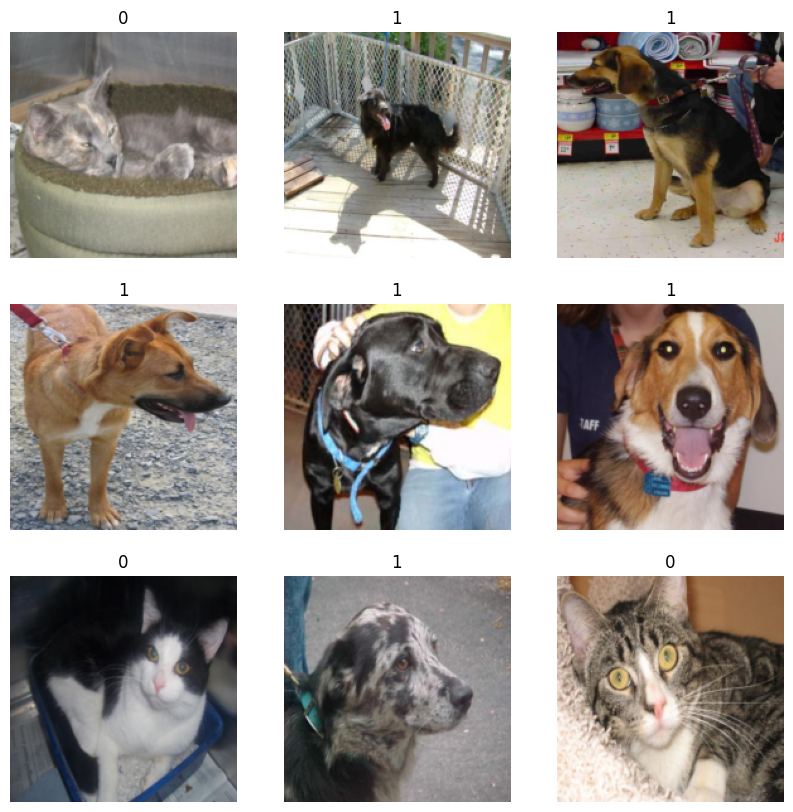

In [8]:
plt.figure(figsize=(10, 10))
for images, labels in train_loader:
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        image = images[i] / 2 + 0.5
        plt.imshow(np.transpose(image.numpy(), (1, 2, 0)))
        plt.title(int(labels[i]))
        plt.axis("off")
    break
plt.show()


### Using image data augmentation

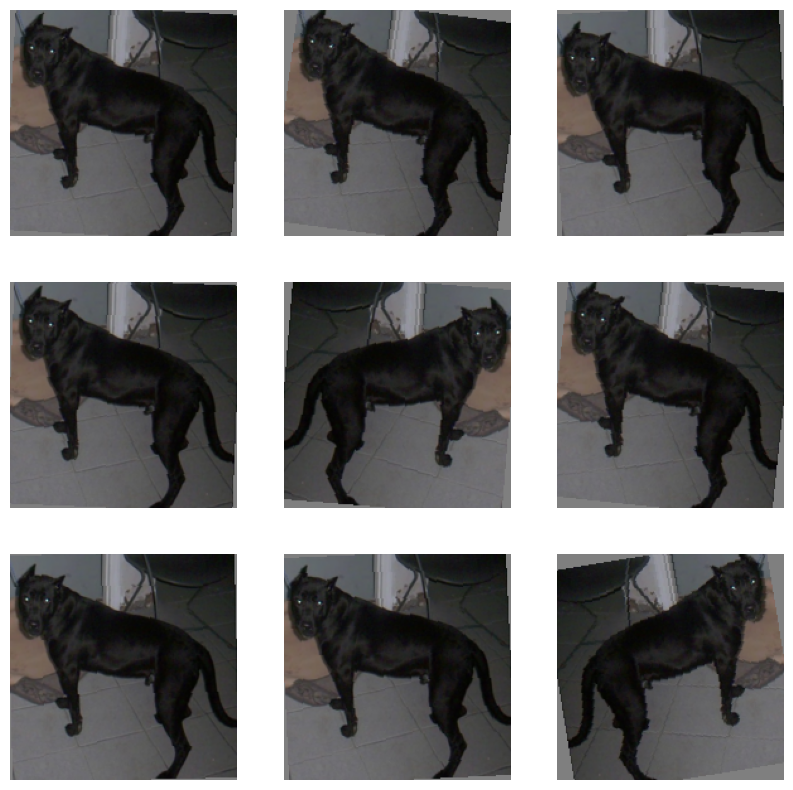

In [9]:
data_augmentation_transforms = transforms.Compose([
    transforms.Resize(image_size),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=10)
])

def data_augmentation(images):
    augmented_images = []
    for img in images:
        augmented_img = data_augmentation_transforms(img)
        augmented_images.append(augmented_img)
    return torch.stack(augmented_images)


plt.figure(figsize=(10, 10))
for images, _ in train_loader:
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        image = augmented_images[0] / 2 + 0.5
        plt.imshow(np.transpose(image.numpy(), (1, 2, 0)))
        plt.axis("off")
    break
plt.show()


### Build a model

In [10]:
class SeperableConv2d(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.depthwise = nn.Conv2d(
            in_channels, in_channels, kernel_size=3, padding=1, *args,  groups=in_channels, **kwargs)
        self.pointwise = nn.Conv2d(
            in_channels, out_channels, kernel_size=(1, 1))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.depthwise(x)
        x = self.pointwise(x)
        return x


class Unit(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.cn1 = nn.Sequential(
            nn.ReLU(),
            SeperableConv2d(in_channels, out_channels),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            SeperableConv2d(out_channels, out_channels),
            nn.BatchNorm2d(out_channels),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

        self.cn2 = nn.Conv2d(in_channels, out_channels,
                             kernel_size=1, stride=2)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        out1 = self.cn1(x)
        out2 = self.cn2(x)
        return out1 + out2


class CNN(nn.Module):
    def __init__(self, in_channels: int, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.layers = nn.ModuleList()

        self.layers.append(nn.Sequential(
            nn.Conv2d(in_channels,  out_channels=128,
                      kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()))

        channels = [128, 256, 512, 728]
        for index, size in enumerate(channels[:-1]):
            self.layers.append(
                Unit(in_channels=size, out_channels=channels[index+1]))

        self.layers.append(nn.Sequential(
            SeperableConv2d(in_channels=728, out_channels=1024),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Dropout1d(),
            nn.Linear(1024, 1)))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        for layer in self.layers:
            x = layer(x)
        return x

In [11]:
def run(model, normal_init=False):
  torch.manual_seed(42)
  model.to(device=device)

  learning_rate = 3e-4
  num_epochs = 25

  def init_weight(m):
    if isinstance(m, nn.Linear):
      nn.init.kaiming_normal_(m.weight)
      nn.init.zeros_(m.bias)

  if normal_init:
    model.apply(init_weight)

  criterion = nn.BCEWithLogitsLoss()
  optimizer = optim.Adam(model.parameters(), lr=learning_rate)

  best_accuracy = 0.0
  patience = 5
  epoch_num_improve = 0

  for epoch in range(num_epochs):

    model.train()
    train_loss = 0.0
    train_correct = 0

    for images, labels in tqdm(train_loader):
      images = images.to(device=device)
      labels = labels.float().to(device=device).unsqueeze(1)

      output = model(images)
      loss = criterion(output, labels)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      train_loss += loss.item()

      predicted = (output > 0.0 ).float()
      train_correct += (predicted == labels).sum().item()
    train_accuracy = train_correct / len(train_ds)
    train_loss /= len(train_loader)

    model.eval()
    test_correct = 0

    with torch.no_grad():
      for images, labels in test_loader:
        images = images.to(device=device)
        labels = labels.float().to(device=device).unsqueeze(1)

        output = model(images)

        predicted = (output > 0.0 ).float()
        test_correct += (predicted == labels).sum().item()
    test_accuracy = test_correct / len(train_ds)

    print(f"Epoch: {epoch + 1}/{num_epochs} | Train loss: {train_loss:.4f} | Train Acc: {train_accuracy:.4f} | Test Acc: {test_accuracy:.4f}")

    if test_accuracy > best_accuracy:
      best_accuracy = test_accuracy
      epoch_num_improve = 0
      torch.save(model.state_dict(), "best_model.pth")
    else:
      epoch_num_improve += 1
      if epoch_num_improve > patience:
        print(f"Early stopping, best accuracy {best_accuracy}")
        break

In [12]:
model = CNN(in_channels=3)

In [13]:
print(model)

CNN(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): Unit(
      (cn1): Sequential(
        (0): ReLU()
        (1): SeperableConv2d(
          (depthwise): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=128)
          (pointwise): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1))
        )
        (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): ReLU()
        (4): SeperableConv2d(
          (depthwise): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=256)
          (pointwise): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
        )
        (5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (6): MaxPool2d(kernel_size=3, stride=2, paddi

In [18]:
run(model, normal_init=True)

100%|██████████| 586/586 [03:47<00:00,  2.58it/s]


Epoch: 1/25 | Train loss: 0.3598 | Train Acc: 0.7467 | Test Acc: 0.2141


100%|██████████| 586/586 [03:46<00:00,  2.58it/s]


Epoch: 2/25 | Train loss: 0.3727 | Train Acc: 0.7353 | Test Acc: 0.2282


100%|██████████| 586/586 [03:49<00:00,  2.55it/s]


Epoch: 3/25 | Train loss: 0.3727 | Train Acc: 0.7393 | Test Acc: 0.2332


100%|██████████| 586/586 [03:49<00:00,  2.55it/s]


Epoch: 4/25 | Train loss: 0.3626 | Train Acc: 0.7478 | Test Acc: 0.2320


100%|██████████| 586/586 [03:49<00:00,  2.56it/s]


Epoch: 5/25 | Train loss: 0.3624 | Train Acc: 0.7451 | Test Acc: 0.2147


100%|██████████| 586/586 [03:47<00:00,  2.58it/s]


Epoch: 6/25 | Train loss: 0.3610 | Train Acc: 0.7408 | Test Acc: 0.2250


100%|██████████| 586/586 [03:47<00:00,  2.57it/s]


Epoch: 7/25 | Train loss: 0.3650 | Train Acc: 0.7456 | Test Acc: 0.2336


100%|██████████| 586/586 [03:48<00:00,  2.57it/s]


Epoch: 8/25 | Train loss: 0.3616 | Train Acc: 0.7458 | Test Acc: 0.2326


100%|██████████| 586/586 [03:47<00:00,  2.58it/s]


Epoch: 9/25 | Train loss: 0.3612 | Train Acc: 0.7427 | Test Acc: 0.2347


100%|██████████| 586/586 [03:47<00:00,  2.58it/s]


Epoch: 10/25 | Train loss: 0.3570 | Train Acc: 0.7491 | Test Acc: 0.2332


100%|██████████| 586/586 [03:47<00:00,  2.58it/s]


Epoch: 11/25 | Train loss: 0.3611 | Train Acc: 0.7419 | Test Acc: 0.2275


100%|██████████| 586/586 [03:47<00:00,  2.58it/s]


Epoch: 12/25 | Train loss: 0.3649 | Train Acc: 0.7467 | Test Acc: 0.2330


100%|██████████| 586/586 [03:46<00:00,  2.59it/s]


Epoch: 13/25 | Train loss: 0.3677 | Train Acc: 0.7426 | Test Acc: 0.2353


100%|██████████| 586/586 [03:46<00:00,  2.58it/s]


Epoch: 14/25 | Train loss: 0.3584 | Train Acc: 0.7485 | Test Acc: 0.2330


100%|██████████| 586/586 [03:46<00:00,  2.58it/s]


Epoch: 15/25 | Train loss: 0.3640 | Train Acc: 0.7464 | Test Acc: 0.2301


100%|██████████| 586/586 [03:47<00:00,  2.58it/s]


Epoch: 16/25 | Train loss: 0.3589 | Train Acc: 0.7454 | Test Acc: 0.2306


100%|██████████| 586/586 [03:46<00:00,  2.59it/s]


Epoch: 17/25 | Train loss: 0.3605 | Train Acc: 0.7456 | Test Acc: 0.2355


100%|██████████| 586/586 [03:46<00:00,  2.58it/s]


Epoch: 18/25 | Train loss: 0.3578 | Train Acc: 0.7482 | Test Acc: 0.2361


100%|██████████| 586/586 [03:48<00:00,  2.57it/s]


Epoch: 19/25 | Train loss: 0.3621 | Train Acc: 0.7438 | Test Acc: 0.2341


100%|██████████| 586/586 [03:47<00:00,  2.58it/s]


Epoch: 20/25 | Train loss: 0.3591 | Train Acc: 0.7458 | Test Acc: 0.2349


100%|██████████| 586/586 [03:47<00:00,  2.58it/s]


Epoch: 21/25 | Train loss: 0.3639 | Train Acc: 0.7448 | Test Acc: 0.2346


100%|██████████| 586/586 [03:47<00:00,  2.57it/s]


Epoch: 22/25 | Train loss: 0.3568 | Train Acc: 0.7473 | Test Acc: 0.2195


100%|██████████| 586/586 [03:47<00:00,  2.58it/s]


Epoch: 23/25 | Train loss: 0.3660 | Train Acc: 0.7408 | Test Acc: 0.2350


100%|██████████| 586/586 [03:47<00:00,  2.58it/s]


Epoch: 24/25 | Train loss: 0.3608 | Train Acc: 0.7481 | Test Acc: 0.2344
Early stopping, best accuracy 0.23606364801366936


This image is 72.85% cat and 27.15% dog.


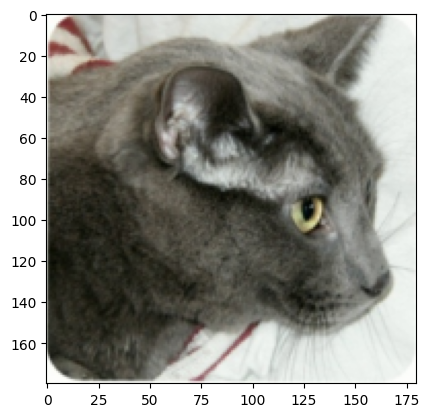

In [15]:
image_size = (180, 180)

image_path = "PetImages/Cat/6779.jpg"
image = Image.open(image_path)

transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor()])

image = transform(image)

plt.imshow(np.transpose(image.numpy(), (1, 2, 0)))

model.eval()
with torch.no_grad():
    image = image.to(device=device)
    predictions = model(image.unsqueeze(0))


score = float(nn.Sigmoid()(predictions).item())
print(f"This image is {100 * (1 - score):.2f}% cat and {100 * score:.2f}% dog.")